# Ligand similarity cutoffs

This notebook explores the effect of applying ligand similarity cutoffs prior to calculating docking success rates.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
hybrid_results = pd.read_csv("../data/hybrid_results.csv", index_col=0)
posit_results = pd.read_csv("../data/posit_results.csv", index_col=0)

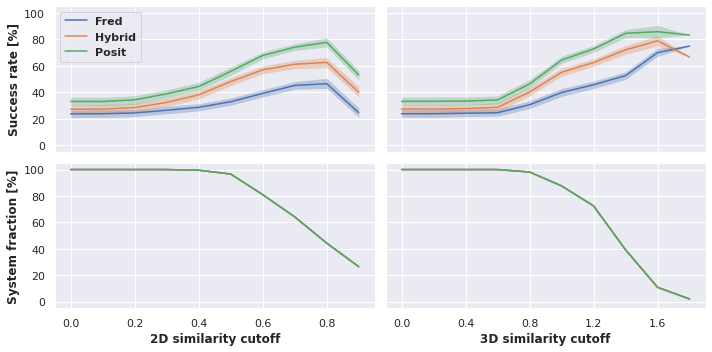

In [5]:
def plot_similarity_cutoffs(fred_results, hybrid_results, posit_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # 2 * 2 subplots
    fig, axes = plt.subplots(2, 2, sharey=True, figsize=(10, 5))
    
    # sample 2D similarity cutoffs
    sampled_success_rates = []
    for method, results in zip(["Fred", "Hybrid", "Posit"], [fred_results, hybrid_results, posit_results]):
        for cutoff in [x / 10 for x in range(10)]:
            results_selection = results[results["fingerprint_similarity"] >= cutoff]
            system_fraction = (
                len(results_selection["ligand_pdb_id"].unique()) / len(results["ligand_pdb_id"].unique())
            ) * 100
            sampled_success_rates_i =[]
            for _ in range(n_bootstrap):
                sampled_results = results_selection.groupby(["ligand_pdb_id"]).sample(n=1, replace=True)
                sampled_success_labels = (sampled_results["rmsd"] <= 2).to_list()
                sampled_success_rates_i.append(
                    (sum(sampled_success_labels) / len(sampled_success_labels)) * 100
                )
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_cutoff = (1 - ci) / 2
            lower_bound = sampled_success_rates_i[int(n_bootstrap * ci_cutoff)]
            upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + ci_cutoff))]
            sampled_success_rates.append([cutoff, method, mean, lower_bound, upper_bound, system_fraction])
    # plot 2D similarity cutoffs
    sampled_success_rates = pd.DataFrame(
        sampled_success_rates, 
        columns=["2d_similarity_cutoff", "method", "success_rate", "ci_lower", "ci_upper", "system_fraction"]
    )
    sns.lineplot(
        data=sampled_success_rates, 
        x="2d_similarity_cutoff", 
        y="system_fraction", 
        hue="method", 
        ax=axes[1][0]
    )
    axes[1][0].set_ylabel("System fraction [%]", fontweight="bold")
    axes[1][0].set_xlabel("2D similarity cutoff", fontweight="bold")
    axes[1][0].set_xlim([-0.05, 0.95])
    axes[1][0].set_ylim([-5, 105])
    axes[1][0].get_legend().remove()

    ax = sns.lineplot(data=sampled_success_rates, x="2d_similarity_cutoff", y="success_rate", hue="method", ci=None, ax=axes[0][0])
    axes[0][0].xaxis.set_ticklabels([])
    axes[0][0].set_xlabel("")
    axes[0][0].set_ylabel("Success rate [%]", fontweight="bold")
    axes[0][0].set_ylim([-5, 105])
    axes[0][0].set_xlim([-0.05, 0.95])
    axes[0][0].legend(prop=dict(weight="bold"), fancybox=True)
    # plot ci
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["2d_similarity_cutoff"], 
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[0].get_color(),
        linewidth=0
    )
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["2d_similarity_cutoff"], 
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[1].get_color(),
        linewidth=0
    )
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["2d_similarity_cutoff"], 
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[2].get_color(),
        linewidth=0
    )
    
    # sample 3D similarity cutoffs
    sampled_success_rates2 = []
    for method, results in zip(["Fred", "Hybrid", "Posit"], [fred_results, hybrid_results, posit_results]):
        for cutoff in [(x / 10) * 2 for x in range(10)]:
            results_selection = results[results["shape_similarity"] >= cutoff]
            system_fraction = (
                len(results_selection["ligand_pdb_id"].unique()) / len(results["ligand_pdb_id"].unique())
            ) * 100
            sampled_success_rates_i = []
            for _ in range(n_bootstrap):
                sampled_results = results_selection.groupby(["ligand_pdb_id"]).sample(n=1, replace=True)
                sampled_success_labels = (sampled_results["rmsd"] <= 2).to_list()
                sampled_success_rates_i.append(
                    (sum(sampled_success_labels) / len(sampled_success_labels)) * 100
                )
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_cutoff = (1 - ci) / 2
            lower_bound = sampled_success_rates_i[int(n_bootstrap * ci_cutoff)]
            upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + ci_cutoff))]
            sampled_success_rates2.append([cutoff, method, mean, lower_bound, upper_bound, system_fraction])
    # plot 3D similarity cutoffs
    sampled_success_rates2 = pd.DataFrame(
        sampled_success_rates2, columns=["3d_similarity_cutoff", "method", "success_rate", "ci_lower", "ci_upper", "system_fraction"]
    )    
    sns.lineplot(
        data=sampled_success_rates2, 
        x="3d_similarity_cutoff", 
        y="system_fraction", 
        hue="method", 
        ax=axes[1][1]
    )
    axes[1][1].set_xlabel("3D similarity cutoff", fontweight="bold")
    axes[1][1].set_xlim([-0.1, 1.9])
    axes[1][1].set_xticks([0, 0.4, 0.8, 1.2, 1.6])
    axes[1][1].get_legend().remove()
    
    ax = sns.lineplot(data=sampled_success_rates2, x="3d_similarity_cutoff", y="success_rate", hue="method", ci=None, ax=axes[0][1])
    
    axes[0][1].set_xlabel("")
    axes[0][1].xaxis.set_ticklabels([])
    axes[0][1].set_xlim([-0.1, 1.9])
    axes[0][1].set_xticks([0, 0.4, 0.8, 1.2, 1.6])
    axes[0][1].get_legend().remove()
    # plot ci
    ax.fill_between(
        sampled_success_rates2[sampled_success_rates2["method"] == "Fred"]["3d_similarity_cutoff"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Fred"]["ci_lower"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Fred"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[0].get_color(),
        linewidth=0
    )
    ax.fill_between(
        sampled_success_rates2[sampled_success_rates2["method"] == "Hybrid"]["3d_similarity_cutoff"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Hybrid"]["ci_lower"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Hybrid"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[1].get_color(),
        linewidth=0
    )
    ax.fill_between(
        sampled_success_rates2[sampled_success_rates2["method"] == "Posit"]["3d_similarity_cutoff"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Posit"]["ci_lower"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Posit"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[2].get_color(),
        linewidth=0
    )
    plt.tight_layout()
    plt.savefig(directory / "similarity_cutoffs.pdf", dpi=300)
    
    return sampled_success_rates, sampled_success_rates2

success_rates_2d_similarity, success_rates_3d_similarity = plot_similarity_cutoffs(
    fred_results, hybrid_results, posit_results
)

In [6]:
success_rates_2d_similarity

,2d_similarity_cutoff,method,success_rate,ci_lower,ci_upper,system_fraction
0,0.0,Fred,23.673514,20.882852,26.485569,100.000000
1,0.1,Fred,23.753141,20.882852,26.825127,100.000000
2,0.2,Fred,24.376740,21.561969,26.994907,100.000000
3,0.3,Fred,26.445331,23.769100,29.371817,100.000000
4,0.4,Fred,28.616212,25.938567,31.399317,99.490662
5,0.5,Fred,32.870826,30.228471,35.676626,96.604414
6,0.6,Fred,39.150524,36.477987,41.928721,80.984720
7,0.7,Fred,45.223280,42.328042,48.148148,64.176570
8,0.8,Fred,46.502682,42.911877,50.574713,44.312394
9,0.9,Fred,24.558333,21.153846,28.205128,26.485569


In [7]:
success_rates_3d_similarity

,3d_similarity_cutoff,method,success_rate,ci_lower,ci_upper,system_fraction
0,0.0,Fred,23.734805,21.052632,26.655348,100.000000
1,0.2,Fred,23.767063,20.882852,26.825127,100.000000
2,0.4,Fred,24.180645,21.561969,27.164686,100.000000
3,0.6,Fred,24.515789,21.901528,27.504244,100.000000
4,0.8,Fred,30.599135,27.681661,33.564014,98.132428
5,1.0,Fred,39.829070,36.821705,42.829457,87.606112
6,1.2,Fred,45.721077,42.857143,48.477752,72.495756
7,1.4,Fred,52.617749,49.783550,55.411255,39.219015
8,1.6,Fred,70.014062,67.187500,73.437500,10.865874
9,1.8,Fred,75.000000,75.000000,75.000000,2.037351


## Investigate the drop in the success rate for 2D similarity of 0.9

The drop in the success rate for docking into structures with a co-crystallized ligand with a fingerprint similarity of 0.9 is surprising considering the given trend. An analysis of the systems available for docking revealed that ATP analogues are harder to dock than the other compounds and that the portion of ATP analogues is particularly high in the docking data subset satisfying the 0.9 fingerprint similarity cutoff.

In [8]:
# consider first pose only
hybrid_results = hybrid_results[hybrid_results["pose"] == 1]

In [9]:
print("Filtering for docking runs with fingerprint similarity of 0.8 or higher to the co-crystallized ligand ...")
results_selection = hybrid_results[hybrid_results["fingerprint_similarity"] >= 0.8]
remaining_systems = results_selection[["ligand_pdb_id", "ligand_expo_id"]].drop_duplicates(ignore_index=True)
print("Number of systems left to reproduce:", len(remaining_systems))
print(
    "Portion of ATP analogues: ", 
    round(len(remaining_systems[remaining_systems["ligand_expo_id"].isin(["ACP", "ANP", "ADP", "ATP"])]) / len(remaining_systems), 2)
)
atp_analogues_results = results_selection[results_selection["ligand_expo_id"].isin(["ACP", "ANP", "ADP", "ATP"])]
non_atp_analogues_results = results_selection[~results_selection["ligand_expo_id"].isin(["ACP", "ANP", "ADP", "ATP"])]
print(
    "Average success rate for ATP analogues:",
    round(len(atp_analogues_results[atp_analogues_results["rmsd"] <= 2.0]) / len(atp_analogues_results), 2)
)
print(
    "Average success rate for non ATP analogues:",
    round(len(non_atp_analogues_results[non_atp_analogues_results["rmsd"] <= 2.0]) / len(non_atp_analogues_results), 2)
)

Filtering for docking runs with fingerprint similarity of 0.8 or higher to the co-crystallized ligand ...
Number of systems left to reproduce: 261
Portion of ATP analogues:  0.51
Average success rate for ATP analogues: 0.5
Average success rate for non ATP analogues: 0.73


In [10]:
print("Filtering for docking runs with fingerprint similarity of 0.9 or higher to the co-crystallized ligand ...")
results_selection = hybrid_results[hybrid_results["fingerprint_similarity"] >= 0.9]
remaining_systems = results_selection[["ligand_pdb_id", "ligand_expo_id"]].drop_duplicates(ignore_index=True)
print("Number of systems left to reproduce:", len(remaining_systems))
print(
    "Portion of ATP analogues: ", 
    round(len(remaining_systems[remaining_systems["ligand_expo_id"].isin(["ACP", "ANP", "ADP", "ATP"])]) / len(remaining_systems), 2)
)
atp_analogues_results = results_selection[results_selection["ligand_expo_id"].isin(["ACP", "ANP", "ADP", "ATP"])]
non_atp_analogues_results = results_selection[~results_selection["ligand_expo_id"].isin(["ACP", "ANP", "ADP", "ATP"])]
print(
    "Average success rate for ATP analogues:",
    round(len(atp_analogues_results[atp_analogues_results["rmsd"] <= 2.0]) / len(atp_analogues_results), 2)
)
print(
    "Average success rate for non ATP analogues:",
    round(len(non_atp_analogues_results[non_atp_analogues_results["rmsd"] <= 2.0]) / len(non_atp_analogues_results), 2)
)

Filtering for docking runs with fingerprint similarity of 0.9 or higher to the co-crystallized ligand ...
Number of systems left to reproduce: 156
Portion of ATP analogues:  0.74
Average success rate for ATP analogues: 0.37
Average success rate for non ATP analogues: 0.69


In [11]:
print("Filtering for docking runs with shape similarity of 1.6 or higher to the co-crystallized ligand ...")
results_selection = hybrid_results[hybrid_results["shape_similarity"] >= 1.6]
remaining_systems = results_selection[["ligand_pdb_id", "ligand_expo_id"]].drop_duplicates(ignore_index=True)
print("Number of systems left to reproduce:", len(remaining_systems))
print(
    "Portion of ATP analogues: ", 
    round(len(remaining_systems[remaining_systems["ligand_expo_id"].isin(["ACP", "ANP", "ADP", "ATP"])]) / len(remaining_systems), 2)
)

Filtering for docking runs with shape similarity of 1.6 or higher to the co-crystallized ligand ...
Number of systems left to reproduce: 64
Portion of ATP analogues:  0.0
